In [12]:
import gymnasium as gym
import ale_py
import time

gym.register_envs(ale_py)

env = gym.make("ALE/Bowling-v5", render_mode="human")
observation, info = env.reset(seed=42)

print("Observation shape:", observation.shape)
print("Observation data type:", observation.dtype)
print("Action space:", env.action_space)

num_rounds = 1
for round_num in range(num_rounds):
    print(f"\n--- Round {round_num + 1} ---")
    terminated = False
    truncated = False
    total_reward = 0
    step = 0
    while not terminated and not truncated:
        action = env.action_space.sample()
        next_observation, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        step += 1
        print(f"Step: {step}, Action: {action}, Reward: {reward}, Terminated: {terminated}, Truncated: {truncated}")
        env.render()
        time.sleep(0.1)  # Add a small delay to see what's happening

        # In Bowling, an episode typically ends after all frames are played.
        # We'll rely on the environment's 'terminated' flag to signal the end of the game.
        if terminated or truncated:
            print(f"Round {round_num + 1} finished after {step} steps with total reward: {total_reward}")
            observation, info = env.reset()
            break

    if round_num == num_rounds - 1:
        print("\n--- End of 10 Rounds ---")
        break

env.close()

Observation shape: (210, 160, 3)
Observation data type: uint8
Action space: Discrete(6)

--- Round 1 ---
Step: 1, Action: 5, Reward: 0.0, Terminated: False, Truncated: False
Step: 2, Action: 0, Reward: 0.0, Terminated: False, Truncated: False
Step: 3, Action: 1, Reward: 0.0, Terminated: False, Truncated: False
Step: 4, Action: 0, Reward: 0.0, Terminated: False, Truncated: False
Step: 5, Action: 3, Reward: 0.0, Terminated: False, Truncated: False
Step: 6, Action: 5, Reward: 0.0, Terminated: False, Truncated: False
Step: 7, Action: 3, Reward: 0.0, Terminated: False, Truncated: False
Step: 8, Action: 2, Reward: 0.0, Terminated: False, Truncated: False
Step: 9, Action: 5, Reward: 0.0, Terminated: False, Truncated: False
Step: 10, Action: 2, Reward: 0.0, Terminated: False, Truncated: False
Step: 11, Action: 2, Reward: 0.0, Terminated: False, Truncated: False
Step: 12, Action: 0, Reward: 0.0, Terminated: False, Truncated: False
Step: 13, Action: 0, Reward: 0.0, Terminated: False, Truncated: 

In [13]:
# Manual frame stacking and preprocessing
import gymnasium as gym
import numpy as np
import cv2
from collections import deque

class ManualPreprocessWrapper(gym.Wrapper):
    def _init_(self, env, frame_stack=4):
        super()._init_(env)
        self.frame_stack = frame_stack
        self.frames = deque(maxlen=frame_stack)

        self.observation_space = gym.spaces.Box(
            low=0,
            high=255,
            shape=(frame_stack, 84, 84),
            dtype=np.uint8
        )

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        processed = self._preprocess(obs)
        for _ in range(self.frame_stack):
            self.frames.append(processed)
        return np.stack(self.frames, axis=0), info

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        processed = self._preprocess(obs)
        self.frames.append(processed)
        return np.stack(self.frames, axis=0), reward, terminated, truncated, info

    def _preprocess(self, obs):
        gray = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
        resized = cv2.resize(gray, (84, 84), interpolation=cv2.INTER_AREA)
        return resized.astype(np.uint8)

## Import the Needed Libraries

In [14]:
import gymnasium as gym
import ale_py
import time
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical # For sampling actions
import numpy as np # For array manipulations

## Define Actor and Critic Networks

In [15]:
# --- PPO Specific Components ---

# Helper function for common CNN layers (optional, but good practice)
def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

class ActorNetwork(nn.Module):
    def __init__(self, num_actions):
        super(ActorNetwork, self).__init__()
        # Assuming observation shape is (210, 160, 3) - (H, W, C)
        # PyTorch CNNs expect (C, H, W)
        self.network = nn.Sequential(
            layer_init(nn.Conv2d(3, 32, kernel_size=8, stride=4)), # Input channels = 3 (RGB)
            nn.ReLU(),
            layer_init(nn.Conv2d(32, 64, kernel_size=4, stride=2)),
            nn.ReLU(),
            layer_init(nn.Conv2d(64, 64, kernel_size=3, stride=1)),
            nn.ReLU(),
            nn.Flatten(),
            # Calculate the flattened size carefully based on conv output
            # For (210,160,3) input:
            # After conv1: (210-8)/4 + 1 = 51.5 -> 51. (160-8)/4+1 = 39
            # After conv2: (51-4)/2 + 1 = 24.5 -> 24. (39-4)/2+1 = 18.5 -> 18
            # After conv3: (24-3)/1 + 1 = 22. (18-3)/1+1 = 16
            # Flattened size = 64 * 22 * 16 = 22528
            # This might need adjustment based on actual output dimensions or padding.
            # A common practice is to use env.observation_space.shape and a dummy forward pass to get the size.
            layer_init(nn.Linear(64 * 22 * 16, 512)), # Example flattened size, ADJUST THIS
            nn.ReLU(),
            layer_init(nn.Linear(512, num_actions), std=0.01) # Output layer for action logits
        )

    def forward(self, x):
        # Preprocess x: normalize and permute dimensions if necessary
        # x is expected to be (Batch, Height, Width, Channels) from Gym
        # Permute to (Batch, Channels, Height, Width) for PyTorch Conv2D
        x = x.permute(0, 3, 1, 2) / 255.0 # Normalize pixel values
        return self.network(x)

    def get_action_and_value(self, x, action=None): # Renaming to include value if actor and critic share layers
        logits = self.forward(x)
        probs = Categorical(logits=logits)
        if action is None:
            action = probs.sample()
        return action, probs.log_prob(action), probs.entropy() # Return action, log_prob, entropy

class CriticNetwork(nn.Module):
    def __init__(self):
        super(CriticNetwork, self).__init__()
        # Similar CNN structure as the Actor, or can share layers
        self.network = nn.Sequential(
            layer_init(nn.Conv2d(3, 32, kernel_size=8, stride=4)),
            nn.ReLU(),
            layer_init(nn.Conv2d(32, 64, kernel_size=4, stride=2)),
            nn.ReLU(),
            layer_init(nn.Conv2d(64, 64, kernel_size=3, stride=1)),
            nn.ReLU(),
            nn.Flatten(),
            layer_init(nn.Linear(64 * 22 * 16, 512)), # Example flattened size, ADJUST THIS
            nn.ReLU(),
            layer_init(nn.Linear(512, 1), std=1.0) # Output layer for state value
        )

    def forward(self, x):
        x = x.permute(0, 3, 1, 2) / 255.0 # Normalize pixel values
        return self.network(x)

    def get_value(self, x):
        return self.forward(x)

# IMPORTANT: Calculate the input size to the first nn.Linear layer in Actor and Critic
# after the convolutional and flatten layers dynamically.
# You can do this by creating a dummy input and passing it through the conv layers:
# temp_env = gym.make("ALE/Bowling-v5")
# obs_shape = temp_env.observation_space.shape # (210, 160, 3)
# cnn_base = nn.Sequential(
#     layer_init(nn.Conv2d(obs_shape[2], 32, kernel_size=8, stride=4)), nn.ReLU(),
#     layer_init(nn.Conv2d(32, 64, kernel_size=4, stride=2)), nn.ReLU(),
#     layer_init(nn.Conv2d(64, 64, kernel_size=3, stride=1)), nn.ReLU(),
#     nn.Flatten()
# )
# with torch.no_grad():
#     # Create a dummy batch of observations (1, C, H, W)
#     dummy_obs = torch.zeros(1, obs_shape[2], obs_shape[0], obs_shape[1])
#     flattened_size = cnn_base(dummy_obs).shape[1]
# print(f"Calculated flattened size: {flattened_size}")
# # Replace 64 * 22 * 16 with this 'flattened_size'


## Define PPO Hyperparameters

In [16]:
# PPO Hyperparameters
LEARNING_RATE = 2.5e-4
NUM_ENVS = 1 # For now, we're not vectorizing, but good to have as a variable
NUM_STEPS_PER_ROLLOUT = 128 # Number of steps to run in the environment per policy update
GAMMA = 0.99 # Discount factor
GAE_LAMBDA = 0.95 # Lambda for GAE
NUM_MINIBATCHES = 4 # Number of minibatches to split a batch into
CLIP_EPS = 0.1 # PPO clip parameter
NUM_EPOCHS_PER_UPDATE = 4 # Number of epochs to update policy per batch
ENTROPY_COEF = 0.01 # Entropy coefficient
VALUE_LOSS_COEF = 0.5 # Value function loss coefficient
MAX_GRAD_NORM = 0.5 # Max gradient norm for clipping
TARGET_KL = None # Optional: Target KL divergence for early stopping

# Training settings
TOTAL_TIMESTEPS = 500_000 # Total number of timesteps to train for
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Initializations

In [17]:
# 1. Environment Setup (Your existing code)
gym.register_envs(ale_py)
# If you want to try without human rendering for speed:
# env = gym.make("ALE/Bowling-v5")
env = gym.make("ALE/Bowling-v5", render_mode="human") # Keep for now if you want to see it
observation_shape = env.observation_space.shape
num_actions = env.action_space.n

# --- PPO Specific Components ---
# Dynamically calculate flattened size
cnn_base_test = nn.Sequential(
    layer_init(nn.Conv2d(observation_shape[2], 32, kernel_size=8, stride=4)), nn.ReLU(),
    layer_init(nn.Conv2d(32, 64, kernel_size=4, stride=2)), nn.ReLU(),
    layer_init(nn.Conv2d(64, 64, kernel_size=3, stride=1)), nn.ReLU(),
    nn.Flatten()
)
with torch.no_grad():
    dummy_obs_for_size = torch.zeros(1, observation_shape[2], observation_shape[0], observation_shape[1])
    flattened_size = cnn_base_test(dummy_obs_for_size).shape[1]
print(f"Dynamically calculated flattened size for Linear layer: {flattened_size}")

# Re-define Actor and Critic with the correct flattened_size
class ActorNetwork(nn.Module): # Redefine with correct flattened_size
    def __init__(self, num_actions, input_channels=3): # input_channels for clarity
        super(ActorNetwork, self).__init__()
        self.network = nn.Sequential(
            layer_init(nn.Conv2d(input_channels, 32, kernel_size=8, stride=4)),
            nn.ReLU(),
            layer_init(nn.Conv2d(32, 64, kernel_size=4, stride=2)),
            nn.ReLU(),
            layer_init(nn.Conv2d(64, 64, kernel_size=3, stride=1)),
            nn.ReLU(),
            nn.Flatten(),
            layer_init(nn.Linear(flattened_size, 512)),
            nn.ReLU(),
            layer_init(nn.Linear(512, num_actions), std=0.01)
        )
    def forward(self, x):
        # x is (Batch, Height, Width, Channels)
        x = x.permute(0, 3, 1, 2) / 255.0 # (Batch, Channels, Height, Width)
        return self.network(x)
    # ... (get_action_and_value remains the same)
    def get_action_and_value(self, x, action=None):
        logits = self.forward(x)
        probs = Categorical(logits=logits)
        if action is None:
            action = probs.sample()
        return action, probs.log_prob(action), probs.entropy()

class CriticNetwork(nn.Module): # Redefine with correct flattened_size
    def __init__(self, input_channels=3):
        super(CriticNetwork, self).__init__()
        self.network = nn.Sequential(
            layer_init(nn.Conv2d(input_channels, 32, kernel_size=8, stride=4)),
            nn.ReLU(),
            layer_init(nn.Conv2d(32, 64, kernel_size=4, stride=2)),
            nn.ReLU(),
            layer_init(nn.Conv2d(64, 64, kernel_size=3, stride=1)),
            nn.ReLU(),
            nn.Flatten(),
            layer_init(nn.Linear(flattened_size, 512)),
            nn.ReLU(),
            layer_init(nn.Linear(512, 1), std=1.0)
        )
    def forward(self, x):
        x = x.permute(0, 3, 1, 2) / 255.0
        return self.network(x)
    # ... (get_value remains the same)
    def get_value(self, x):
        return self.forward(x)


actor = ActorNetwork(num_actions, input_channels=observation_shape[2]).to(DEVICE)
critic = CriticNetwork(input_channels=observation_shape[2]).to(DEVICE)
actor_optimizer = optim.Adam(actor.parameters(), lr=LEARNING_RATE, eps=1e-5)
critic_optimizer = optim.Adam(critic.parameters(), lr=LEARNING_RATE, eps=1e-5)

# Storage for rollouts
obs_storage = torch.zeros((NUM_STEPS_PER_ROLLOUT, NUM_ENVS) + observation_shape).to(DEVICE)
actions_storage = torch.zeros((NUM_STEPS_PER_ROLLOUT, NUM_ENVS)).to(DEVICE) # For Discrete actions
logprobs_storage = torch.zeros((NUM_STEPS_PER_ROLLOUT, NUM_ENVS)).to(DEVICE)
rewards_storage = torch.zeros((NUM_STEPS_PER_ROLLOUT, NUM_ENVS)).to(DEVICE)
dones_storage = torch.zeros((NUM_STEPS_PER_ROLLOUT, NUM_ENVS)).to(DEVICE)
values_storage = torch.zeros((NUM_STEPS_PER_ROLLOUT, NUM_ENVS)).to(DEVICE)


Dynamically calculated flattened size for Linear layer: 22528


## Evaluation Setupt

In [18]:
eval_env = gym.make("ALE/Bowling-v5")  
eval_freq = 10  # Evaluate every 10 updates
eval_results = []  # Stores (global_step, mean_reward, std_reward)

def evaluate(policy, num_episodes=10):
    policy.eval()
    rewards = []
    for _ in range(num_episodes):
        obs, _ = eval_env.reset()
        episode_reward = 0
        while True:
            with torch.no_grad():
                action, _, _ = policy.get_action_and_value(
                    torch.Tensor(obs).unsqueeze(0).to(DEVICE)
                )
            obs, reward, terminated, truncated, _ = eval_env.step(action.item())
            episode_reward += reward
            if terminated or truncated:
                break
        rewards.append(episode_reward)
    policy.train()
    return np.mean(rewards), np.std(rewards)

## Main loop to run in timesteps and not in num_games

In [19]:
# --- Training Loop ---
global_step = 0
num_updates = TOTAL_TIMESTEPS // (NUM_STEPS_PER_ROLLOUT * NUM_ENVS)

# Initial observation
# IMPORTANT: env.reset() returns a tuple (observation, info). We only need observation.
# Also, observation needs to be converted to a tensor and have a batch dimension.
current_obs_tuple = env.reset(seed=42)
current_obs = torch.Tensor(current_obs_tuple[0]).to(DEVICE).unsqueeze(0) # Add batch dim for single env
current_done = torch.zeros(NUM_ENVS).to(DEVICE) # For single env, NUM_ENVS=1

print("Starting training...")
for update in range(1, num_updates + 1):
    # --- Data Collection (Rollout Phase) ---
    for step in range(0, NUM_STEPS_PER_ROLLOUT):
        global_step += 1 * NUM_ENVS
        obs_storage[step] = current_obs # current_obs already has batch dim (1, H, W, C)

        with torch.no_grad(): # Don't need gradients for action selection and value estimation here
            action, logprob, _ = actor.get_action_and_value(current_obs) # current_obs is (1, H, W, C)
            value = critic.get_value(current_obs)

        actions_storage[step] = action.squeeze() # Squeeze if action is (1,1) to (1)
        logprobs_storage[step] = logprob.squeeze()
        values_storage[step] = value.squeeze()

        # Execute action in the environment
        # env.step returns (observation, reward, terminated, truncated, info)
        next_obs_tuple, reward, terminated, truncated, info = env.step(action.cpu().numpy().item()) # Send one action
        done = terminated or truncated

        rewards_storage[step] = torch.tensor(reward).to(DEVICE).view(-1) # Ensure reward is a tensor
        # current_obs needs to be (1, H, W, C)
        current_obs = torch.Tensor(next_obs_tuple).to(DEVICE).unsqueeze(0)
        current_done = torch.tensor(done).to(DEVICE).view(-1) # Ensure done is a tensor
        dones_storage[step] = current_done

        if 'episode' in info: # Gymnasium environments often provide episode stats in info
            print(f"Global Step: {global_step}, Episode Reward: {info['episode']['r']}")

        if env.render_mode == "human":
            env.render()
            time.sleep(0.01) # Adjust sleep time

    # --- Learning Phase ---
    with torch.no_grad():
        # Calculate advantages using GAE
        # Get value of the last state in the rollout
        next_value = critic.get_value(current_obs).reshape(1, -1) # current_obs is (1,H,W,C)
        advantages = torch.zeros_like(rewards_storage).to(DEVICE)
        lastgaelam = 0
        for t in reversed(range(NUM_STEPS_PER_ROLLOUT)):
            if t == NUM_STEPS_PER_ROLLOUT - 1:
                nextnonterminal = 1.0 - current_done.float() # current_done is for the state *after* last step
                nextvalues = next_value
            else:
                nextnonterminal = 1.0 - dones_storage[t + 1]
                nextvalues = values_storage[t + 1]
            delta = rewards_storage[t] + GAMMA * nextvalues * nextnonterminal - values_storage[t]
            advantages[t] = lastgaelam = delta + GAMMA * GAE_LAMBDA * nextnonterminal * lastgaelam
        returns = advantages + values_storage # Q-values estimates

    # Flatten the batch for training
    # obs_storage is (NUM_STEPS, NUM_ENVS, H, W, C) -> (NUM_STEPS*NUM_ENVS, H, W, C)
    b_obs = obs_storage.reshape((-1,) + observation_shape)
    b_logprobs = logprobs_storage.reshape(-1)
    b_actions = actions_storage.reshape((-1,) + env.action_space.shape) # If action space is not scalar
    b_advantages = advantages.reshape(-1)
    b_returns = returns.reshape(-1)
    b_values = values_storage.reshape(-1)

    # Optimize policy and value networks
    b_inds = np.arange(NUM_STEPS_PER_ROLLOUT * NUM_ENVS)
    clipfracs = []
    for epoch in range(NUM_EPOCHS_PER_UPDATE):
        np.random.shuffle(b_inds)
        for start in range(0, NUM_STEPS_PER_ROLLOUT * NUM_ENVS, NUM_STEPS_PER_ROLLOUT * NUM_ENVS // NUM_MINIBATCHES):
            end = start + NUM_STEPS_PER_ROLLOUT * NUM_ENVS // NUM_MINIBATCHES
            mb_inds = b_inds[start:end]

            # Get new logprobs, entropy, and value for the minibatch observations
            _, newlogprob, entropy = actor.get_action_and_value(b_obs[mb_inds], b_actions.long()[mb_inds])
            newvalue = critic.get_value(b_obs[mb_inds]).view(-1)

            logratio = newlogprob - b_logprobs[mb_inds]
            ratio = logratio.exp()

            with torch.no_grad():
                old_approx_kl = (-logratio).mean()
                approx_kl = ((ratio - 1) - logratio).mean()
                clipfracs += [((ratio - 1.0).abs() > CLIP_EPS).float().mean().item()]

            mb_advantages = b_advantages[mb_inds]
            # Normalize advantages (optional but often helpful)
            mb_advantages = (mb_advantages - mb_advantages.mean()) / (mb_advantages.std() + 1e-8)

            # Policy loss
            pg_loss1 = -mb_advantages * ratio
            pg_loss2 = -mb_advantages * torch.clamp(ratio, 1 - CLIP_EPS, 1 + CLIP_EPS)
            pg_loss = torch.max(pg_loss1, pg_loss2).mean()

            # Value loss
            v_loss_unclipped = (newvalue - b_returns[mb_inds]) ** 2
            v_clipped = b_values[mb_inds] + torch.clamp(
                newvalue - b_values[mb_inds],
                -CLIP_EPS,
                CLIP_EPS,
            )
            v_loss_clipped = (v_clipped - b_returns[mb_inds]) ** 2
            v_loss_max = torch.max(v_loss_unclipped, v_loss_clipped)
            v_loss = 0.5 * v_loss_max.mean() # Can also use 0.5 * ((newvalue - b_returns[mb_inds])**2).mean()

            entropy_loss = entropy.mean()
            loss = pg_loss - ENTROPY_COEF * entropy_loss + v_loss * VALUE_LOSS_COEF

            actor_optimizer.zero_grad()
            
            # Actor optimizer step
            actor_optimizer.zero_grad()
            actor_loss = pg_loss - ENTROPY_COEF * entropy_loss
            actor_loss.backward(retain_graph=True) # Retain graph if critic loss depends on actor output somehow, or separate
            nn.utils.clip_grad_norm_(actor.parameters(), MAX_GRAD_NORM)
            actor_optimizer.step()

            # Critic optimizer step
            critic_optimizer.zero_grad()
            # Value loss was: v_loss = 0.5 * ((newvalue - b_returns[mb_inds])**2).mean()
            critic_true_loss = 0.5 * ((newvalue - b_returns[mb_inds])**2).mean() # Recalculate critic loss from its output
            critic_true_loss.backward()
            nn.utils.clip_grad_norm_(critic.parameters(), MAX_GRAD_NORM)
            critic_optimizer.step()


        if TARGET_KL is not None and approx_kl > TARGET_KL:
            print(f"Approx KL {approx_kl.item()} exceeded target {TARGET_KL}. Stopping epoch early.")
            break
    # End of learning phase for one update

    # --- Evaluation & Metrics ---
    if update % eval_freq == 0 or update == 1:
        mean_reward, std_reward = evaluate(actor)
        eval_results.append((global_step, mean_reward, std_reward))
        
        print(f"\n--- Evaluation after Update {update} ---")
        print(f"Total Timesteps: {global_step}")
        print(f"Mean Reward: {mean_reward:.1f} ± {std_reward:.1f}")
        print(f"Current Training Episode Reward: {info['episode']['r'] if 'episode' in info else 'N/A'}")
        
    # --- Periodic Logging ---
    if (update % 10 == 0) or (update == 1):
        print(f"\nUpdate {update}/{num_updates}")
        print(f"Global Step: {global_step}")
        print(f"Approx KL Divergence: {approx_kl.item():.3f}")
        print(f"Clip Fraction: {np.mean(clipfracs):.3f}")
        print(f"Value Loss: {v_loss.item():.3f}")

    # Print some stats
    if (update % 10 == 0) or (update == 1): # Print every 10 updates
        print(f"Update {update}/{num_updates}, Global Timesteps: {global_step}")
        # Add more logging here: average reward, value loss, policy loss, entropy

print("\nTraining completed.")
env.close()
eval_env.close()

Starting training...

--- Evaluation after Update 1 ---
Total Timesteps: 128
Mean Reward: 23.5 ± 4.9
Current Training Episode Reward: N/A

Update 1/3906
Global Step: 128
Approx KL Divergence: 0.002
Clip Fraction: 0.188
Value Loss: 0.004
Update 1/3906, Global Timesteps: 128

--- Evaluation after Update 10 ---
Total Timesteps: 1280
Mean Reward: 22.6 ± 3.1
Current Training Episode Reward: N/A

Update 10/3906
Global Step: 1280
Approx KL Divergence: 0.005
Clip Fraction: 0.166
Value Loss: 1.159
Update 10/3906, Global Timesteps: 1280

--- Evaluation after Update 20 ---
Total Timesteps: 2560
Mean Reward: 21.7 ± 3.7
Current Training Episode Reward: N/A

Update 20/3906
Global Step: 2560
Approx KL Divergence: 0.000
Clip Fraction: 0.000
Value Loss: 0.000
Update 20/3906, Global Timesteps: 2560

--- Evaluation after Update 30 ---
Total Timesteps: 3840
Mean Reward: 24.1 ± 4.6
Current Training Episode Reward: N/A

Update 30/3906
Global Step: 3840
Approx KL Divergence: 0.000
Clip Fraction: 0.000
Value 

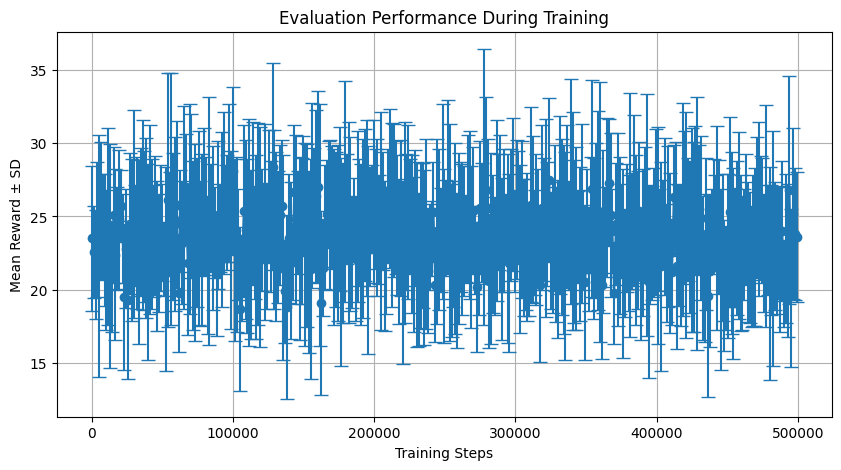

In [20]:
# Plot results
import matplotlib.pyplot as plt
steps, means, stds = zip(*eval_results)

plt.figure(figsize=(10,5))
plt.errorbar(steps, means, yerr=stds, fmt='-o', capsize=5)
plt.title("Evaluation Performance During Training")
plt.xlabel("Training Steps")
plt.ylabel("Mean Reward ± SD")
plt.grid(True)
plt.savefig("training_metrics.png")
plt.show()

<hr>

<hr>

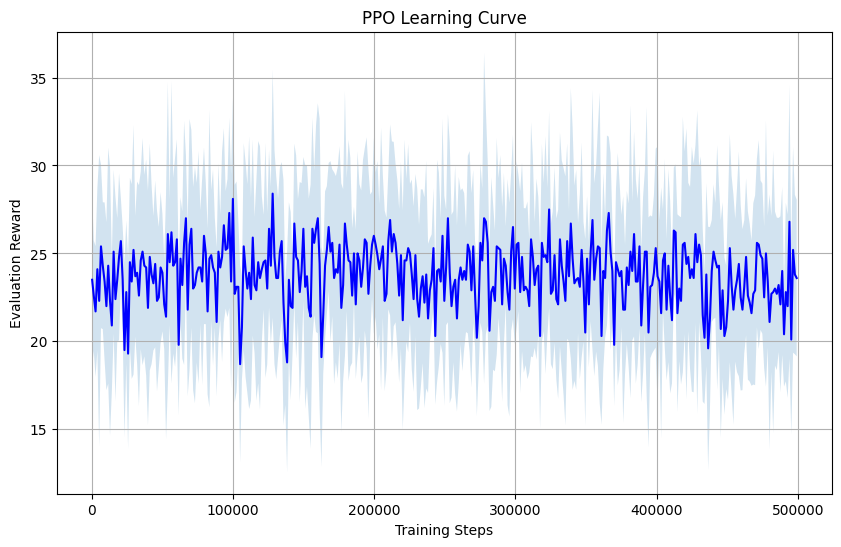

In [21]:
# Plot learning curve
import matplotlib.pyplot as plt

steps, means, stds = zip(*eval_results)

plt.figure(figsize=(10, 6))
plt.plot(steps, means, 'b-', label='Mean Reward')
plt.fill_between(steps, 
                 [m - s for m, s in zip(means, stds)], 
                 [m + s for m, s in zip(means, stds)], 
                 alpha=0.2)
plt.xlabel('Training Steps')
plt.ylabel('Evaluation Reward')
plt.title('PPO Learning Curve')
plt.grid(True)
plt.savefig('learning_curve.png')
plt.show()


<hr>

## New Implementation

In [ ]:
import gymnasium as gym
import ale_py
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import numpy as np
import cv2
from collections import deque
import matplotlib.pyplot as plt

# ======================
# Preprocessing (Frame Stack + Grayscale + Resize)
# ======================
class Preprocessor:
    def __init__(self, frame_stack=4):
        self.frame_stack = frame_stack
        self.frames = deque(maxlen=frame_stack)
        
    def reset(self, obs):
        processed = self._preprocess(obs)
        for _ in range(self.frame_stack):
            self.frames.append(processed)
        return np.stack(self.frames, axis=0)
    
    def step(self, obs):
        processed = self._preprocess(obs)
        self.frames.append(processed)
        return np.stack(self.frames, axis=0)
    
    def _preprocess(self, obs):
        gray = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
        resized = cv2.resize(gray, (84, 84), interpolation=cv2.INTER_AREA)
        return resized.astype(np.uint8)

# ======================
# PPO Network (Shared)
# ======================
class ActorCritic(nn.Module):
    def __init__(self, num_actions, frame_stack=4):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Conv2d(frame_stack, 32, 8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU()
        )
        self.actor = nn.Linear(512, num_actions)
        self.critic = nn.Linear(512, 1)
        # Weight init
        for layer in self.shared:
            if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
                nn.init.orthogonal_(layer.weight, np.sqrt(2))
                nn.init.constant_(layer.bias, 0.0)
        nn.init.orthogonal_(self.actor.weight, 0.01)
        nn.init.constant_(self.actor.bias, 0.0)
        nn.init.orthogonal_(self.critic.weight, 1.0)
        nn.init.constant_(self.critic.bias, 0.0)
    def forward(self, x):
        x = x.float() / 255.0
        features = self.shared(x)
        return self.actor(features), self.critic(features)

# ======================
# Hyperparameters
# ======================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = {
    "num_envs": 1,            # For demo, set to 1. For speed, use >1 with gym.vector
    "num_steps": 128,
    "gamma": 0.99,
    "gae_lambda": 0.95,
    "num_minibatches": 4,
    "clip_eps": 0.1,
    "num_epochs": 4,
    "ent_coef": 0.01,
    "vf_coef": 0.5,
    "max_grad_norm": 0.5,
    "lr": 2.5e-4,
    "frame_stack": 4,
    "total_timesteps": 100_000,
    "eval_freq": 10,         # Evaluate every 10 updates
    "eval_episodes": 10
}

# ======================
# Evaluation Function
# ======================
def evaluate(policy, eval_env, preprocessor, num_episodes=10):
    policy.eval()
    rewards = []
    for _ in range(num_episodes):
        obs, _ = eval_env.reset()
        state = preprocessor.reset(obs)
        episode_reward = 0
        terminated = False
        truncated = False
        while not (terminated or truncated):
            with torch.no_grad():
                logits, _ = policy(torch.tensor(state).unsqueeze(0).to(DEVICE))
                action = torch.argmax(logits, dim=1).item()
            next_obs, reward, terminated, truncated, _ = eval_env.step(action)
            state = preprocessor.step(next_obs)
            episode_reward += reward
        rewards.append(episode_reward)
    policy.train()
    return np.mean(rewards), np.std(rewards)

# ======================
# Training Loop
# ======================
def train():
    # Environment setup
    env = gym.make("ALE/Bowling-v5", render_mode=None)
    eval_env = gym.make("ALE/Bowling-v5", render_mode=None)
    preprocessor = Preprocessor(frame_stack=config["frame_stack"])
    eval_preprocessor = Preprocessor(frame_stack=config["frame_stack"])
    model = ActorCritic(env.action_space.n, config["frame_stack"]).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=config["lr"], eps=1e-5)
    
    obs_storage = torch.zeros((config["num_steps"], config["num_envs"], config["frame_stack"], 84, 84), dtype=torch.uint8)
    actions_storage = torch.zeros((config["num_steps"], config["num_envs"]), dtype=torch.int64)
    logprobs_storage = torch.zeros((config["num_steps"], config["num_envs"]))
    rewards_storage = torch.zeros((config["num_steps"], config["num_envs"]))
    dones_storage = torch.zeros((config["num_steps"], config["num_envs"]))
    values_storage = torch.zeros((config["num_steps"], config["num_envs"]))

    eval_results = []

    obs, _ = env.reset(seed=42)
    state = preprocessor.reset(obs)
    done = False

    global_step = 0
    num_updates = config["total_timesteps"] // (config["num_steps"] * config["num_envs"])

    print("Starting training...")
    for update in range(1, num_updates + 1):
        for step in range(config["num_steps"]):
            global_step += 1
            obs_storage[step, 0] = torch.tensor(state)
            dones_storage[step, 0] = float(done)
            with torch.no_grad():
                logits, value = model(torch.tensor(state).unsqueeze(0).to(DEVICE))
                dist = Categorical(logits=logits)
                action = dist.sample()
                logprob = dist.log_prob(action)
            actions_storage[step, 0] = action.item()
            logprobs_storage[step, 0] = logprob.item()
            values_storage[step, 0] = value.item()
            next_obs, reward, terminated, truncated, _ = env.step(action.item())
            rewards_storage[step, 0] = reward
            done = terminated or truncated
            state = preprocessor.step(next_obs)
            if done:
                next_obs, _ = env.reset()
                state = preprocessor.reset(next_obs)
                done = False

        # --- Learning Phase ---
        with torch.no_grad():
            _, next_value = model(torch.tensor(state).unsqueeze(0).to(DEVICE))
            next_value = next_value.item()
            advantages = torch.zeros_like(rewards_storage)
            lastgaelam = 0
            for t in reversed(range(config["num_steps"])):
                if t == config["num_steps"] - 1:
                    nextnonterminal = 1.0 - done
                    nextvalues = next_value
                else:
                    nextnonterminal = 1.0 - dones_storage[t + 1, 0]
                    nextvalues = values_storage[t + 1, 0]
                delta = rewards_storage[t, 0] + config["gamma"] * nextvalues * nextnonterminal - values_storage[t, 0]
                advantages[t, 0] = lastgaelam = delta + config["gamma"] * config["gae_lambda"] * nextnonterminal * lastgaelam
            returns = advantages + values_storage

        # Flatten the batch for training
        b_obs = obs_storage.reshape((-1, config["frame_stack"], 84, 84)).float().to(DEVICE)
        b_logprobs = logprobs_storage.reshape(-1).to(DEVICE)
        b_actions = actions_storage.reshape(-1).to(DEVICE)
        b_advantages = advantages.reshape(-1).to(DEVICE)
        b_returns = returns.reshape(-1).to(DEVICE)
        b_values = values_storage.reshape(-1).to(DEVICE)

        # Normalize advantages
        b_advantages = (b_advantages - b_advantages.mean()) / (b_advantages.std() + 1e-8)

        # Optimize policy and value networks
        inds = np.arange(config["num_steps"] * config["num_envs"])
        for epoch in range(config["num_epochs"]):
            np.random.shuffle(inds)
            for start in range(0, len(inds), len(inds) // config["num_minibatches"]):
                end = start + len(inds) // config["num_minibatches"]
                mb_inds = inds[start:end]
                logits, value = model(b_obs[mb_inds])
                dist = Categorical(logits=logits)
                newlogprob = dist.log_prob(b_actions[mb_inds])
                entropy = dist.entropy().mean()
                ratio = (newlogprob - b_logprobs[mb_inds]).exp()
                pg_loss1 = -b_advantages[mb_inds] * ratio
                pg_loss2 = -b_advantages[mb_inds] * torch.clamp(ratio, 1 - config["clip_eps"], 1 + config["clip_eps"])
                pg_loss = torch.max(pg_loss1, pg_loss2).mean()
                v_loss_unclipped = (value.squeeze() - b_returns[mb_inds]) ** 2
                v_clipped = b_values[mb_inds] + torch.clamp(
                    value.squeeze() - b_values[mb_inds],
                    -config["clip_eps"],
                    config["clip_eps"]
                )
                v_loss_clipped = (v_clipped - b_returns[mb_inds]) ** 2
                v_loss = 0.5 * torch.max(v_loss_unclipped, v_loss_clipped).mean()
                loss = pg_loss - config["ent_coef"] * entropy + config["vf_coef"] * v_loss
                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), config["max_grad_norm"])
                optimizer.step()

        # --- Periodic Evaluation ---
        if update % config["eval_freq"] == 0 or update == 1:
            mean_reward, std_reward = evaluate(model, eval_env, eval_preprocessor, num_episodes=config["eval_episodes"])
            eval_results.append((global_step, mean_reward, std_reward))
            print(f"Eval after update {update}: mean reward {mean_reward:.2f} ± {std_reward:.2f}")

    env.close()
    eval_env.close()

    # --- Visualization ---
    if len(eval_results) > 0:
        steps, means, stds = zip(*eval_results)
        plt.figure(figsize=(10,5))
        plt.errorbar(steps, means, yerr=stds, fmt='-o', capsize=5)
        plt.title("Evaluation Performance During Training")
        plt.xlabel("Training Steps")
        plt.ylabel("Mean Reward ± SD")
        plt.grid(True)
        plt.savefig("ppo_eval_curve.png")
        plt.show()

if __name__ == "__main__":
    train()

Starting training...
Eval after update 1: mean reward 0.00 ± 0.00
Eval after update 10: mean reward 0.00 ± 0.00
Eval after update 20: mean reward 0.00 ± 0.00
Eval after update 30: mean reward 0.00 ± 0.00
Eval after update 40: mean reward 0.00 ± 0.00
Eval after update 50: mean reward 0.00 ± 0.00
Eval after update 60: mean reward 0.00 ± 0.00
Eval after update 70: mean reward 0.00 ± 0.00
Eval after update 80: mean reward 0.00 ± 0.00
Eval after update 90: mean reward 0.00 ± 0.00
Eval after update 100: mean reward 0.00 ± 0.00


KeyboardInterrupt: 

<hr>

In [ ]:
import gymnasium as gym  # Using gymnasium instead of gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Policy Network 
class PolicyNetwork(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super(PolicyNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(obs_dim, 256),
            nn.Tanh(),
            nn.Linear(256, 256),
            nn.Tanh(),
        )
        self.mean = nn.Linear(256, act_dim)
        self.log_std = nn.Parameter(torch.zeros(act_dim))

    def forward(self, x):
        x = self.fc(x)
        return self.mean(x), self.log_std.exp()

    def get_action(self, obs):
        mean, std = self.forward(obs)
        dist = torch.distributions.Normal(mean, std)
        action = dist.sample()
        log_prob = dist.log_prob(action).sum(axis=-1)
        return action, log_prob

# Value Network 
class ValueNetwork(nn.Module):
    def __init__(self, obs_dim):
        super(ValueNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(obs_dim, 256),
            nn.Tanh(),
            nn.Linear(256, 256),
            nn.Tanh(),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        return self.fc(x).squeeze(-1)

# PPO Agent 
class PPOAgent:
    def __init__(self, obs_dim, act_dim, lr=1e-4, gamma=0.95, clip_eps=0.1, ent_coef=0.01):
        self.policy = PolicyNetwork(obs_dim, act_dim)
        self.value = ValueNetwork(obs_dim)
        self.policy_optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        self.value_optimizer = optim.Adam(self.value.parameters(), lr=lr)
        self.gamma = gamma
        self.clip_eps = clip_eps
        self.ent_coef = ent_coef
        self.obs_mean = torch.zeros(obs_dim)
        self.obs_std = torch.ones(obs_dim)

    def compute_advantages(self, rewards, values, dones, next_value):
        advantages = []
        gae = 0
        for step in reversed(range(len(rewards))):
            gae_lambda = 0.92  # Fix typo in variable name
            delta = rewards[step] + self.gamma * (1 - dones[step]) * next_value - values[step]
            gae = delta + self.gamma * gae_lambda * (1 - dones[step]) * gae
            advantages.insert(0, gae)
            next_value = values[step]
        # Normalize AFTER the loop
        advantages = (np.array(advantages) - np.mean(advantages)) / (np.std(advantages) + 1e-8)
        return advantages


    def update(self, obs, actions, log_probs_old, returns, advantages):
        obs = (torch.tensor(obs, dtype=torch.float32) - self.obs_mean) / (self.obs_std + 1e-8)
        actions = torch.tensor(actions, dtype=torch.float32)
        log_probs_old = torch.tensor(log_probs_old, dtype=torch.float32)
        returns = torch.tensor(returns, dtype=torch.float32)
        advantages = torch.tensor(advantages, dtype=torch.float32)

        # Policy update
        mean, std = self.policy(obs)
        dist = torch.distributions.Normal(mean, std)
        log_probs = dist.log_prob(actions).sum(axis=-1)
        ratio = (log_probs - log_probs_old).exp()
        clipped_ratio = torch.clamp(ratio, 1 - self.clip_eps, 1 + self.clip_eps)
        policy_loss = -torch.min(ratio * advantages, clipped_ratio * advantages).mean()

        # Add entropy bonus
        entropy = dist.entropy().mean()
        policy_loss -= self.ent_coef * entropy  # <--- Add this line

        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 0.5)  # Clip gradients
        self.policy_optimizer.step()

        # Value update
        values = self.value(obs)
        value_loss = nn.MSELoss()(values, returns)
        self.value_optimizer.zero_grad()
        value_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.value.parameters(), 0.5)  # Clip gradients
        self.value_optimizer.step()

    def update_normalization(self, obs_buffer):
        obs_tensor = torch.tensor(obs_buffer, dtype=torch.float32)
        batch_mean = torch.mean(obs_tensor, dim=0)
        batch_std = torch.std(obs_tensor, dim=0)
    
        # Update running averages (0.9 momentum)
        self.obs_mean = 0.9 * self.obs_mean + 0.1 * batch_mean
        self.obs_std = 0.9 * self.obs_std + 0.1 * batch_std + 1e-8


# Corrected Training Loop
def train(env_name, total_timesteps=100000):
    env = gym.make(env_name)
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.shape[0]
    agent = PPOAgent(obs_dim, act_dim)
    obs, _ = env.reset()  
    episode_rewards = []
    
    for update in range(2000):
        obs_buffer, act_buffer, logp_buffer, rew_buffer, val_buffer, done_buffer = [], [], [], [], [], []
        
        for t in range(4096):
            # Normalize observation before action selection
            obs_tensor = torch.tensor(obs, dtype=torch.float32)
            normalized_obs = (obs_tensor - agent.obs_mean) / (agent.obs_std + 1e-8)
            action, log_prob = agent.policy.get_action(normalized_obs)
            
            value = agent.value(normalized_obs).item()  # Also normalize for value
            
            next_obs, reward, terminated, truncated, info = env.step(action.detach().numpy())
            done = terminated or truncated
            
            # Store transitions WITH SCALED REWARD
            obs_buffer.append(obs)
            act_buffer.append(action.detach().numpy())
            logp_buffer.append(log_prob.item())
            rew_buffer.append(reward / 16.0)  # Scaled reward
            val_buffer.append(value)
            done_buffer.append(done)
            obs = next_obs
            
            if done:
                obs, _ = env.reset()

        agent.update_normalization(obs_buffer)  # Update stats after batch

        # Compute returns and advantages
        next_value = agent.value(
            (torch.tensor(obs, dtype=torch.float32) - agent.obs_mean) / (agent.obs_std + 1e-8)
        ).item()
        advantages = agent.compute_advantages(rew_buffer, val_buffer, done_buffer, next_value)
        returns = np.array(val_buffer) + np.array(advantages)
        agent.update(obs_buffer, act_buffer, logp_buffer, returns, advantages)
        
        # Evaluation (with normalization)
        if update % 10 == 0:
            eval_rewards = []
            for _ in range(5):
                eval_obs, _ = env.reset()  
                total_reward = 0
                done = False
                while not done:
                    # Normalize eval observation
                    norm_eval_obs = (torch.tensor(eval_obs, dtype=torch.float32) - agent.obs_mean) / (agent.obs_std + 1e-8)
                    action, _ = agent.policy.get_action(norm_eval_obs)
                    eval_obs, reward, terminated, truncated, _ = env.step(action.detach().numpy())
                    done = terminated or truncated
                    total_reward += reward
                eval_rewards.append(total_reward)
            print(f"Eval after update {update}: mean reward {np.mean(eval_rewards):.2f} ± {np.std(eval_rewards):.2f}")


if __name__ == "__main__":
    train("Pendulum-v1")  # Works with Gymnasium's Pendulum


Eval after update 0: mean reward -1207.83 ± 341.35
Eval after update 10: mean reward -1293.99 ± 258.64
Eval after update 20: mean reward -1211.40 ± 78.98
Eval after update 30: mean reward -1303.66 ± 246.18
Eval after update 40: mean reward -1244.04 ± 240.97
Eval after update 50: mean reward -1118.30 ± 223.26
Eval after update 60: mean reward -1073.45 ± 341.78
Eval after update 70: mean reward -1149.77 ± 199.27
Eval after update 80: mean reward -1182.68 ± 283.24
Eval after update 90: mean reward -823.24 ± 102.93
Eval after update 100: mean reward -1155.12 ± 58.24
Eval after update 110: mean reward -1155.54 ± 244.74
Eval after update 120: mean reward -1287.54 ± 258.81
Eval after update 130: mean reward -1070.28 ± 199.89
Eval after update 140: mean reward -998.61 ± 190.33
Eval after update 150: mean reward -1072.27 ± 101.07
Eval after update 160: mean reward -864.58 ± 320.85
Eval after update 170: mean reward -1060.37 ± 234.78
Eval after update 180: mean reward -1135.97 ± 290.92
Eval afte